In [1]:
from spreg import OLS
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

In [169]:
env = gpd.read_file('../raw_data/more_maps/environment_2022.shp')


In [173]:
env

,plr,plr_name,kategorie,bioklima,gruenfl,laerm,luft,geometry
0,01100101,Stülerstraße,zweifach,mittel,schlecht,mittel,hoch,"POLYGON ((387952.642 5818274.558, 387924.234 5..."
1,01100102,Großer Tiergarten,keine starke Belastung,mittel,gut,mittel,mittel,"POLYGON ((389869.327 5820074.331, 389869.304 5..."
2,01100103,Lützowstraße,dreifach,hoch,schlecht,gering,hoch,"POLYGON ((387952.642 5818274.558, 387986.686 5..."
3,01100104,Körnerstraße,zweifach,hoch,gut,mittel,hoch,"POLYGON ((389319.585 5817775.805, 389310.128 5..."
4,01100205,Wilhelmstraße,dreifach,hoch,gut,hoch,hoch,"POLYGON ((389835.709 5819672.186, 389851.284 5..."
...,...,...,...,...,...,...,...,...
537,12601032,Rollbergesiedlung,keine starke Belastung,mittel,gut,gering,mittel,"POLYGON ((386416.954 5829708.452, 386392.827 5..."
538,12601133,Treuenbrietzener Straße,keine starke Belastung,mittel,mittel,mittel,mittel,"POLYGON ((389990.688 5829740.615, 389981.590 5..."
539,12601134,Märkisches Zentrum,keine starke Belastung,mittel,mittel,gering,mittel,"POLYGON ((387367.428 5828619.763, 387315.862 5..."
540,12601235,Dannenwalder Weg,einfach,mittel,schlecht,mittel,mittel,"POLYGON ((389475.323 5828740.790, 389470.683 5..."


<AxesSubplot:>

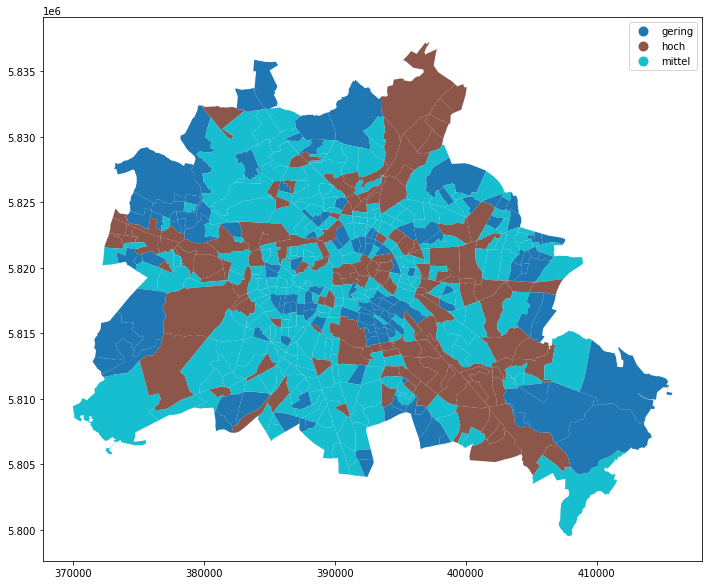

In [172]:
env.plot('laerm', figsize=(15,10),legend=True)

In [65]:
# Load regression gds 
selected = gpd.read_file('../YouthInTheCity/data/regression_gdf.shp')


# Select features manually
selected.drop(columns=['HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
              'schools', 'universiti', 'kindergart','HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'BZR_NAME', 
              'noise', 'vegpm10', 'change', 'ch_rate','public_tra', 'green' ,'other_sch', 'vocat_sch', 
                'sp_nee_sch'], inplace=True)

# Export it as shapefile
selected.to_file('../raw_data/basic_model_gdf.shp')

# Load it again
selected = gpd.read_file('../raw_data/basic_model_gdf.shp')

In [64]:
#selected = pd.concat([selected, transformed_b_age], ignore_index=False, sort=False, axis=1)

In [72]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [73]:
queen.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 28:

In [74]:
y = np.array(selected['child_pov'])
X = selected.drop(columns=[
    'PLR_ID','child_pov', 'geometry']).to_numpy()

In [76]:
selected.columns

Index(['PLR_ID', 'eating', 'culture', 'community', 'health_car', 'public_ser',
       'education', 'outdoor_fa', 'outdoor_le', 'night_life', 'water',
       'mig_rate', 'ave_rent', 'social_hou', 'public_hou', 'dyn_ew',
       'five_y_pls', 'dyn_sales', 'child_pov', 'dyn_unempl', 'air', 'bio',
       'vegpm20', 'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [77]:
columns = [
    'eating', 'culture', 'community', 'health_car', 'public_ser',
    'education', 'outdoor_fa', 'outdoor_le', 'night_life', 'water',
    'mig_rate', 'ave_rent', 'social_hou', 'public_hou', 'dyn_ew',
    'five_y_pls', 'dyn_sales', 'dyn_unempl', 'air', 'bio',
    'vegpm20', 'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
    'stations'
]

In [106]:
basic_ols = OLS(y,
                X,
                w=queen,
                name_y='child_pov',
                name_x=columns,
                name_w='Queen',
                name_ds='basic_model',
                white_test=True,
                gwk=queen,
                spat_diag=True,
                moran=True)

In [107]:
basic_ols.predy

array([[ 1.33558838e+01],
       [ 1.14530143e+01],
       [ 3.88312963e+01],
       [ 1.87966134e+01],
       [ 4.78105613e+01],
       [ 1.74602457e+01],
       [ 5.39631164e+01],
       [ 2.50184796e+01],
       [ 1.41891963e+01],
       [ 1.57430986e+01],
       [ 8.94019043e+00],
       [ 4.03948130e+01],
       [ 1.24199736e+01],
       [ 3.76548102e+01],
       [ 7.60218613e+00],
       [ 3.90539501e+01],
       [ 1.05512179e+01],
       [ 3.10116523e+01],
       [ 2.00930201e+01],
       [ 1.50159447e+01],
       [ 2.09178652e+01],
       [ 1.83068799e+01],
       [ 5.20025042e+01],
       [ 7.47171563e+00],
       [ 1.31266050e+01],
       [ 1.71693693e+01],
       [ 2.15329389e+01],
       [ 3.82382021e+01],
       [ 3.32820582e+01],
       [ 1.64353022e+01],
       [ 5.95041893e+00],
       [ 4.13707923e+01],
       [ 4.10664460e+01],
       [ 1.28802382e+01],
       [ 3.40902870e+01],
       [ 2.45701460e+01],
       [ 5.14740392e+01],
       [ 3.30381889e+01],
       [ 1.6

(array([ 37., 107., 108.,  89.,  74.,  55.,  31.,  21.,  10.,   4.]),
 array([-1.19924026,  6.1451391 , 13.48951846, 20.83389782, 28.17827718,
        35.52265655, 42.86703591, 50.21141527, 57.55579463, 64.90017399,
        72.24455335]),
 <BarContainer object of 10 artists>)

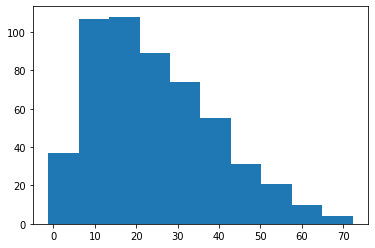

In [108]:
plt.hist(basic_ols.predy.flatten())

<AxesSubplot:>

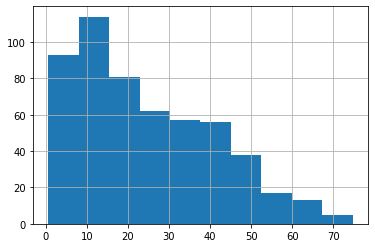

In [109]:
selected['child_pov'].hist()

In [110]:
mae(selected['child_pov'], basic_ols.predy.flatten())

5.73291270015781

In [111]:
np.sqrt(mse(selected['child_pov'], basic_ols.predy.flatten()))

7.734265060162646

In [112]:
print(basic_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :       Queen
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          28
S.D. dependent var  :     16.6701                Degrees of Freedom    :         508
R-squared           :      0.7843
Adjusted R-squared  :      0.7729
Sum squared residual:   32062.907                F-statistic           :     68.4279
Sigma-square        :      63.116                Prob(F-statistic)     :  2.717e-150
S.E. of regression  :       7.945                Log likelihood        :   -1857.025
Sigma-square ML     :      59.819                Akaike info criterion :    3770.050
S.E of regression ML:      7.7343                Schwarz criterion     :    3890.006

-----------------------------------------------------------------------------

In [124]:
rook = libpysal.weights.Rook.from_dataframe(selected)

In [135]:
rook.mean_neighbors

5.373134328358209

In [136]:
rook.histogram

[(2, 13),
 (3, 44),
 (4, 108),
 (5, 152),
 (6, 107),
 (7, 60),
 (8, 26),
 (9, 14),
 (10, 5),
 (11, 3),
 (12, 2),
 (13, 1),
 (14, 1)]

In [141]:
queen.mean_neighbors

5.91044776119403

In [142]:
queen.histogram

[(2, 11),
 (3, 30),
 (4, 73),
 (5, 113),
 (6, 131),
 (7, 90),
 (8, 48),
 (9, 19),
 (10, 12),
 (11, 4),
 (12, 2),
 (13, 2),
 (14, 1)]

In [153]:
selected.crs

<Derived Projected CRS: EPSG:25833>
Name: ETRS89 / UTM zone 33N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Europe between 12°E and 18°E: Austria; Denmark - offshore and offshore; Germany - onshore and offshore; Norway including Svalbard - onshore and offshore.
- bounds: (12.0, 46.4, 18.0, 84.42)
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989 ensemble
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [163]:
inv_dist = libpysal.weights.DistanceBand.from_dataframe(selected, 5000, geom_col='geometry', binary=False)



In [87]:
y_b = selected['child_pov']
X_b = selected.drop(columns=['child_pov', 'PLR_ID','geometry'])

In [88]:
### Perform permutation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
#fit model
model = LinearRegression().fit(X_b,y_b)
#Perform permutation
permutation_score = permutation_importance(model, X_b,y_b, n_repeats=100)
#Unstack results, put in df
importance_df = pd.DataFrame(np.vstack((X_b.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']
#Order by importance
importance_df.sort_values(by='feature importance', ascending = False, inplace=True)
importance_df
#remove feature that have lower feature importance, run the validation score to test the reduced feature

,feature,feature importance
10,mig_rate,0.674796
17,dyn_unempl,0.201032
0,eating,0.165318
8,night_life,0.083097
11,ave_rent,0.037752
13,public_hou,0.029032
16,dyn_sales,0.024267
2,community,0.012712
5,education,0.012283
19,bio,0.011718


In [92]:
medians = selected[columns].merge(
    selected.groupby('ave_rent').residual.median().to_frame(
        'av_rent_residual'),
    how='left',
    left_on='ave_rent',
    right_index=True).sort_values('av_rent_residual').drop(columns=[
    'eating', 'culture', 'community', 'health_car', 'public_ser',
    'education', 'outdoor_fa', 'outdoor_le', 'night_life', 'water',
    'mig_rate','social_hou', 'public_hou', 'dyn_ew',
    'five_y_pls', 'dyn_sales', 'dyn_unempl', 'air', 'bio',
    'vegpm20', 'primary_sc', 'Gymnasium', 'secon_sch', 'priv_schoo', 'kita',
    'stations'
    ])

In [90]:
selected['residual'] = basic_ols.u

In [93]:
medians['ave_rent'].round().value_counts()

9.0     100
11.0     98
8.0      93
10.0     83
13.0     43
12.0     39
14.0     26
15.0     19
7.0      17
16.0     16
1.0       1
4.0       1
Name: ave_rent, dtype: int64

In [95]:
merged_medians = merged_medians.groupby('ave_rent').av_rent_residual.median().to_frame('av_rent_residual')

NameError: name 'merged_medians' is not defined

In [94]:
merged_medians['ave_rent'] = medians['ave_rent'].round()

NameError: name 'merged_medians' is not defined

<AxesSubplot:xlabel='ave_rent'>

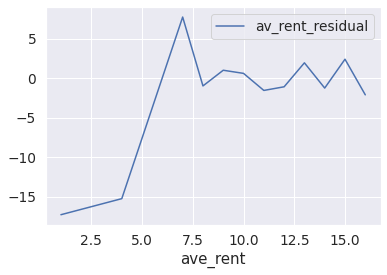

In [63]:
merged_medians.plot()

In [96]:
clusters = list(np.append(importance_df.head(8).feature.values, ('child_pov')))

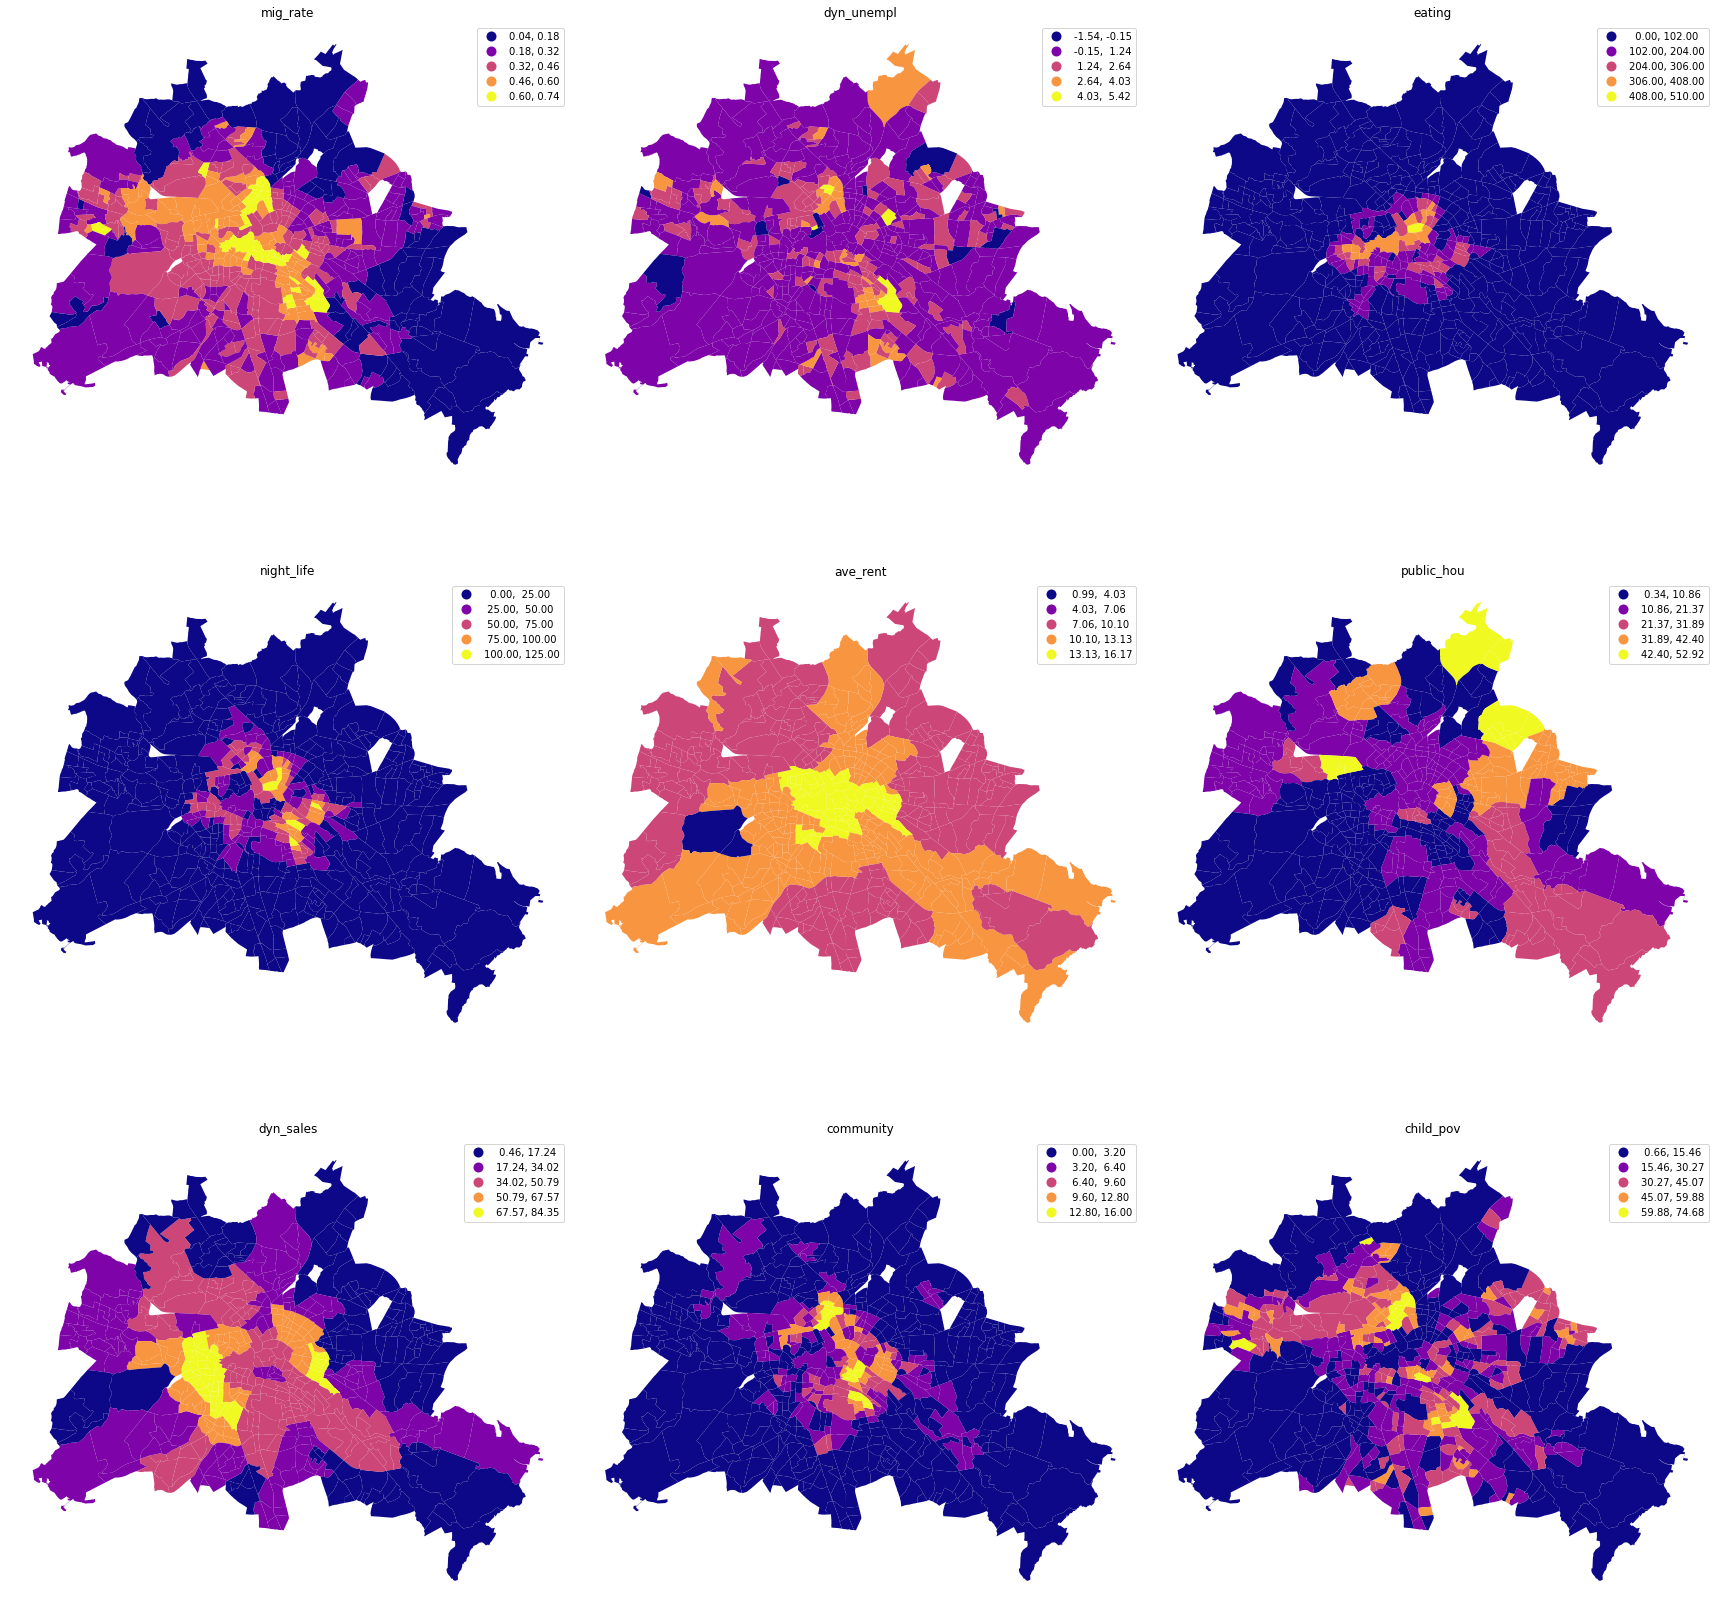

In [97]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(iterable=clusters):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    selected.plot(
        column=col,
        ax=ax,
        scheme="EqualInterval",
        linewidth=0,
        cmap="plasma",
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()

In [34]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [98]:
from esda.moran import Moran

In [99]:
import seaborn

In [101]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(selected[variable], queen) for variable in clusters
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clusters, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
mig_rate,0.733919,0.001
dyn_unempl,0.353758,0.001
eating,0.828862,0.001
night_life,0.817334,0.001
ave_rent,0.808404,0.001
public_hou,0.746134,0.001
dyn_sales,0.832748,0.001
community,0.748545,0.001
child_pov,0.519632,0.001


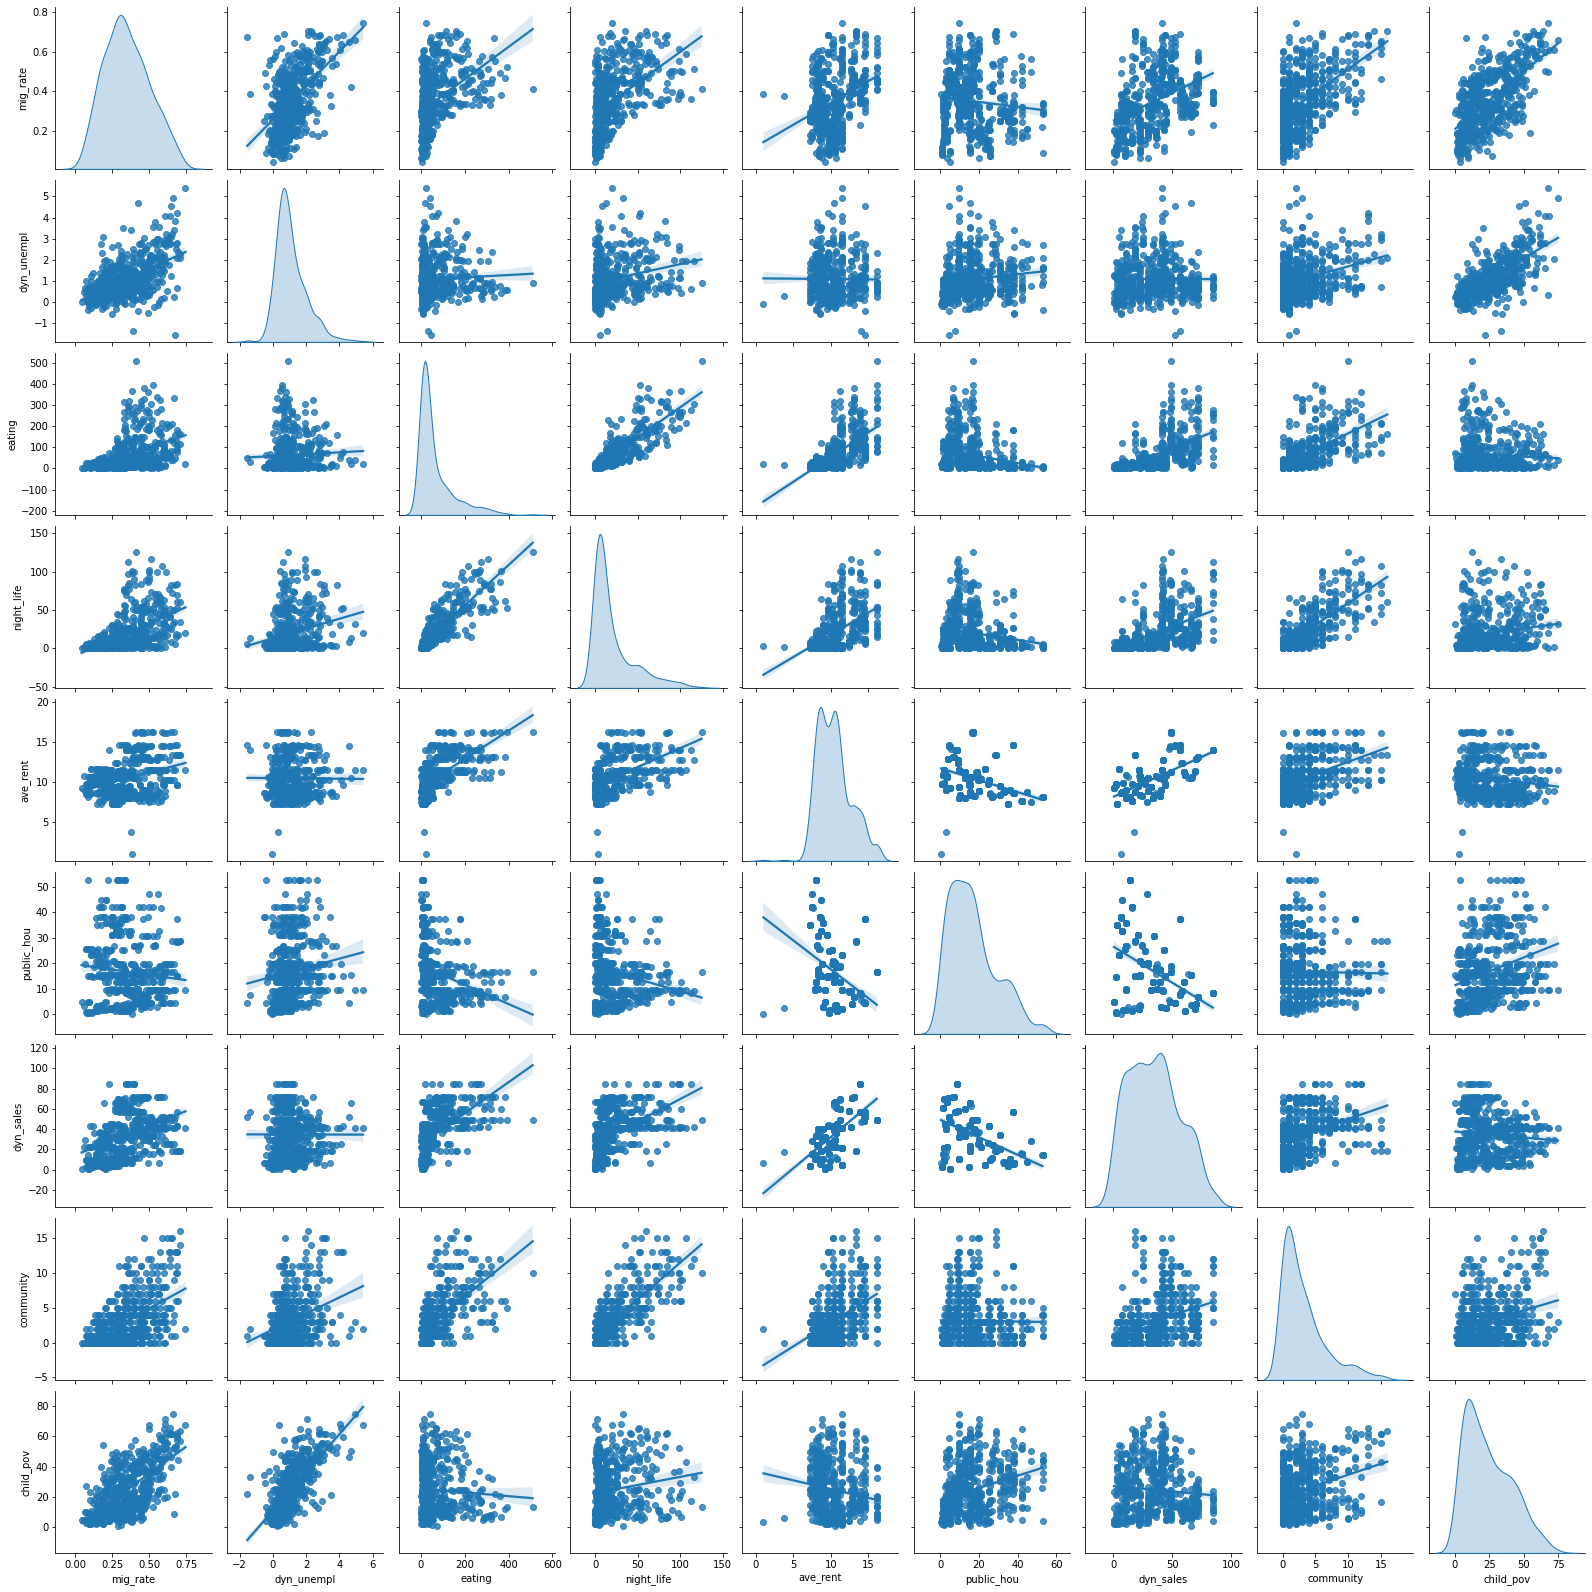

In [102]:
_ = seaborn.pairplot(
    selected[clusters], kind="reg", diag_kind="kde"
)

In [39]:
from sklearn.preprocessing import robust_scale

In [110]:
db_scaled = robust_scale(selected[clusters])

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
k5cls.labels_[:20]

array([2, 3, 0, 1, 0, 2, 0, 0, 2, 2, 2, 3, 2, 0, 3, 1, 2, 0, 2, 3],
      dtype=int32)

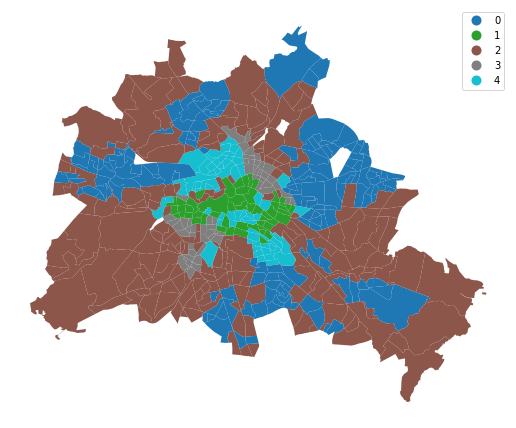

In [115]:
# Assign labels into a column
selected["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
selected.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [113]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
mig_rate,0.332,0.466,0.257,0.352,0.570
dyn_unempl,1.345,0.917,0.525,0.840,2.474
eating,15.241,243.942,26.665,131.673,93.299
night_life,6.698,68.038,6.920,34.018,42.985
public_hou,29.035,11.937,10.842,10.799,13.502
ave_rent,8.450,13.847,10.319,11.772,11.777
education,0.160,1.654,0.330,4.618,1.254
dyn_sales,18.143,58.165,32.530,60.912,41.405
child_pov,33.810,19.381,13.552,14.007,47.581


In [114]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0    162
1     52
2    200
3     55
4     67
dtype: int64